In [319]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [320]:
print(tf.__version__)

2.10.1


In [321]:
dataset_dir = os.path.join(os.getcwd(), 'chest_xray')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_normal_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'NORMAL')))
dataset_train_pneumonia_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'PNEUMONIA')))

dataset_validation_dir = os.path.join(dataset_dir, 'test')
dataset_validation_normal_len = len(os.listdir(
    os.path.join(dataset_validation_dir, 'NORMAL')))
dataset_validation_pneumonia_len = len(os.listdir(
    os.path.join(dataset_validation_dir, 'PNEUMONIA')))


In [322]:
print('Training normal: %s' % dataset_train_normal_len)
print('Training pneumonia: %s' % dataset_train_pneumonia_len)
print('Validation normal: %s' % dataset_validation_normal_len)
print('Validation pneumonia: %s' % dataset_validation_pneumonia_len)

Training normal: 1342
Training pneumonia: 3876
Validation normal: 234
Validation pneumonia: 390


In [323]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel, )


batch_size = 32
epochs = 20
learning_rate = 0.001

class_names = ['cat', 'dog']

In [324]:
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    for features, labels in dataset.take(1):
        for i in range(3):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

Found 5216 files belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

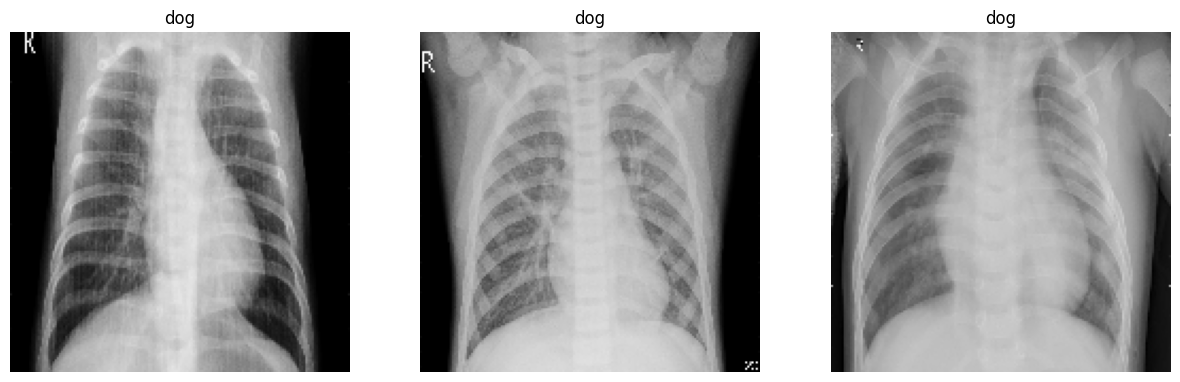

In [325]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)

plot_dataset(dataset_train)


Found 624 files belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

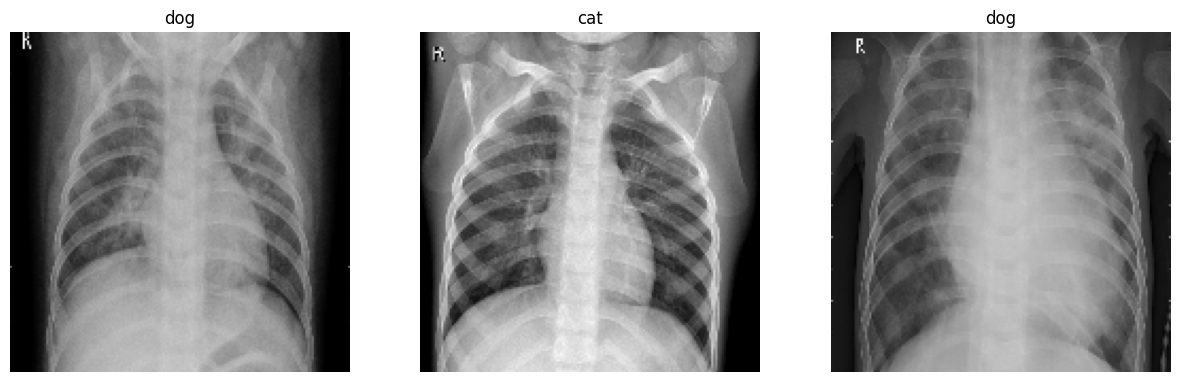

In [326]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

plot_dataset(dataset_validation)

<Figure size 640x480 with 0 Axes>

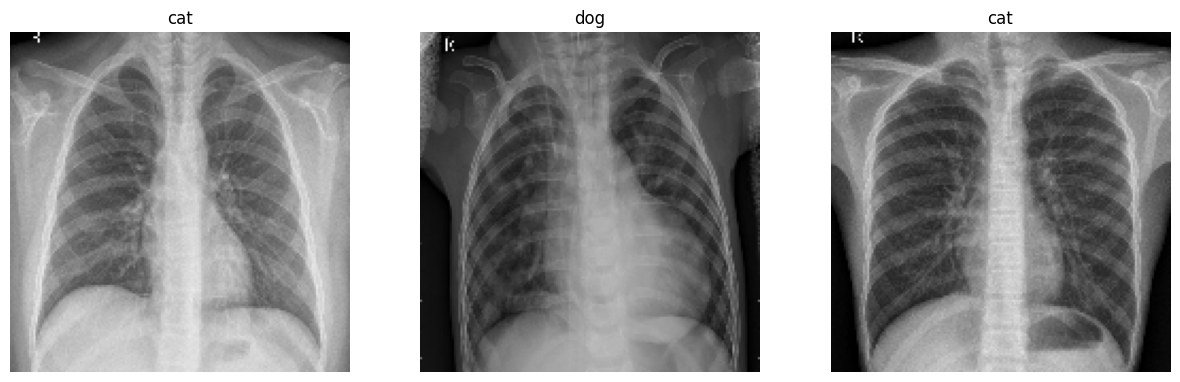

In [327]:
dataset_validation_cardinality = tf.data.experimental.cardinality(
    dataset_validation)
dataset_validation_bathes = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_bathes)
dataset_validation = dataset_validation.skip(dataset_validation_bathes)

plot_dataset(dataset_test)

In [328]:
print('Validation Dataset Cardinality: %d' %
      tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' %
      tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 16
Test Dataset Cardinality: 4


In [329]:
# Realizando data augmentation para aumentar a quantidade de imagens no dataset de treino

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])


In [330]:

# função para plotar imagens do dataset de forma aleatória após data augmentation

def plot_dataset_data_augmentation(dataset):
  plt.gcf().clear()
  plt.figure(figsize=(15, 15))
  
  for features, _ in dataset.take(1):
    feature = features[0]
    
    for i in range(9):
      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))
      
      plt.subplot(3, 3, i + 1)
      plt.axis('off')
      
      plt.imshow(feature_data_augmentation[0]  / image_color_channel_size)
      
      


<Figure size 640x480 with 0 Axes>

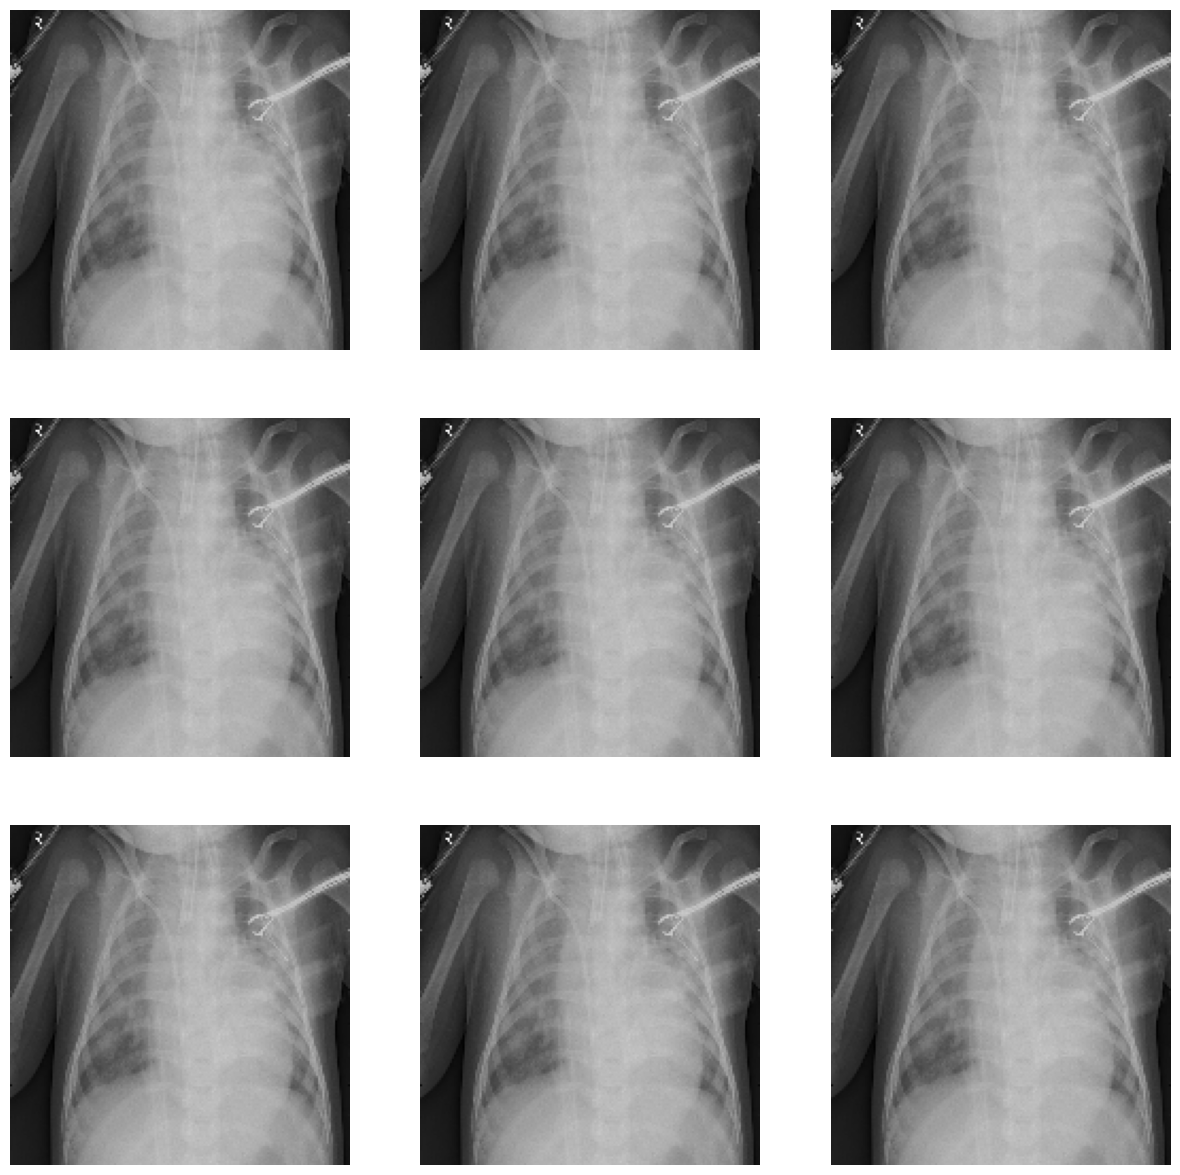

In [331]:
plot_dataset_data_augmentation(dataset_train)

In [ ]:
model_transfer_learning = tf.keras.applications.MobileNetV2(
  input_shape=image_shape,
  include_top=False,
  weights = 'imagenet'
)

model_transfer_learning.trainable = False
model_transfer_learning.summary()

In [333]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(
#         1. / image_color_channel_size,
#         input_shape=image_shape
#     ),
#     data_augmentation,
#     tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#     loss = tf.keras.losses.BinaryCrossentropy(),
#     metrics=['accuracy']
# )


In [334]:
# Option 2
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / (image_color_channel_size/2),
        offset = -1,
        input_shape=image_shape
    ),
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


In [335]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 sequential_34 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_16  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_26 (Dense)            (None, 1)               

In [ ]:
history = model.fit(
  dataset_train,
  validation_data=dataset_validation,
  epochs=epochs,
)

In [ ]:
def plot_model():
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs_range = range(epochs)
  
  plt.gcf().clear()
  plt.figure(figsize=(15,8))
  
  plt.subplot(1,2,1)
  plt.title('Training and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(1,2,2)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower right')
  
  plt.show()

<Figure size 640x480 with 0 Axes>

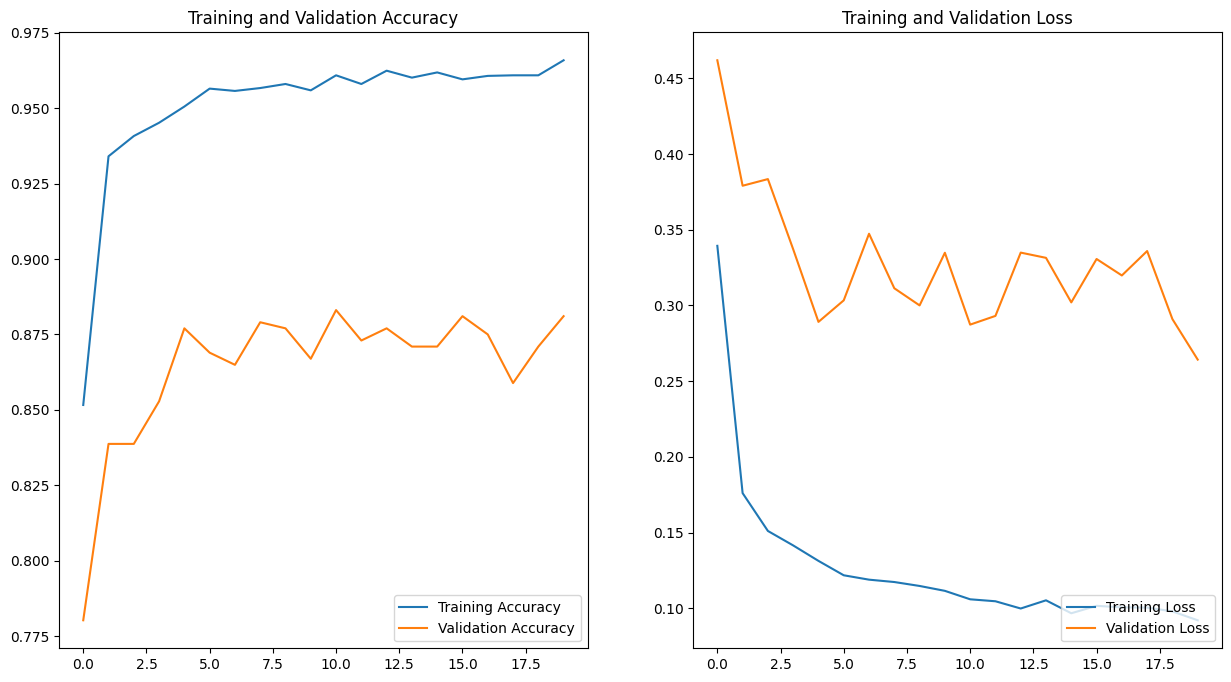

In [ ]:
plot_model()

In [ ]:
def plot_dataset_predictions(dataset):
  features, labels = dataset.as_numpy_iterator().next()
  
  predictions = model.predict_on_batch(features).flatten()
  predictions = tf.where(predictions < 0.5, 0, 1)
  
  print('Labels       %s' % labels)
  print('Predictions  %s' % predictions.numpy())
  
  plt.gcf().clear()
  plt.figure(figsize=(15, 15))
  
  for i in range(9):
    
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    
    plt.imshow(features[i].astype('uint8'))
    plt.title(class_names[predictions[i]])

Labels       [1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1]
Predictions  [1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1]


<Figure size 640x480 with 0 Axes>

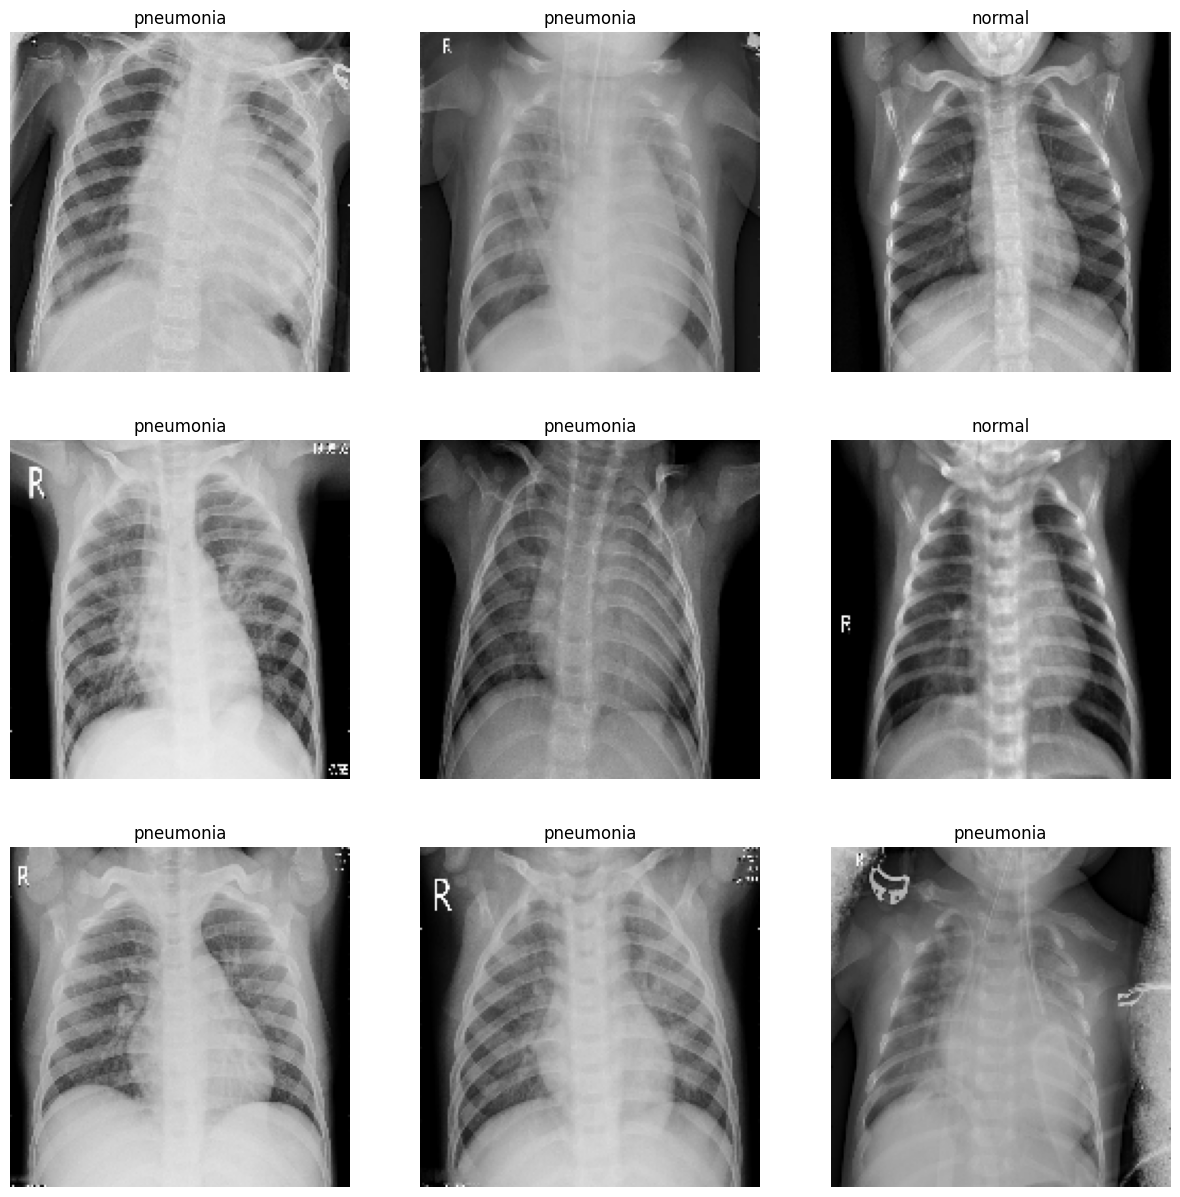

In [ ]:
plot_dataset_predictions(dataset_test)

In [ ]:
model.save('models/normal_and_pneumonia_model.h5')

In [ ]:
model = tf.keras.models.load_model('models/normal_and_pneumonia_model.h5')